# Fine tuning of Decision Tree Classifier model

## for binary classification

In [1]:
from pathlib import Path
# import json
import pandas as pd
import numpy as np

# pipeline utilities
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# validation
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import RepeatedStratifiedKFold, HalvingGridSearchCV
from sklearn.metrics import (
    make_scorer, average_precision_score, classification_report,
    ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay
)

# models
from sklearn.tree import DecisionTreeClassifier

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# get train and test datasets
# if missing then run 'make inputs'
input_dir = '../data/processed/binary'
X_train = pd.read_pickle(Path(f'{input_dir}/X_train.pkl').resolve())
X_test = pd.read_pickle(Path(f'{input_dir}/X_test.pkl').resolve())
y_train = pd.read_pickle(Path(f'{input_dir}/y_train.pkl').resolve())
y_test = pd.read_pickle(Path(f'{input_dir}/y_test.pkl').resolve())

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8103, 10)
(2026, 10)
(8103,)
(2026,)


In [3]:
# numeric features that need transformation
real_features = ['mintemp', 'maxtemp', 'minlight', 'maxlight', 'minsound', 'maxsound', 'co2', 'co2slope']

# scorer: Area under Precision-Recall curve (PR-AUC)
scorer = make_scorer(score_func=average_precision_score)

# 10x Repeated 5-fold cross-validation
kf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
# kf = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=42)

### Tuning without PCA

In [4]:
def get_search_results(X_train, y_train, param_grid: dict) -> dict:
    
    model = DecisionTreeClassifier(random_state=42)

    numTransformer = Pipeline(steps=[
        ('scaler', MinMaxScaler()),
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric', numTransformer, real_features),
        ]
    )

    estimator = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ]
    )

    search = HalvingGridSearchCV(estimator, param_grid, factor=2, cv=kf, scoring=scorer, refit=True, verbose=1)
    search.fit(X_train, y_train)
        
    return search

In [37]:
def report_results(results: dict) -> None:
    
    # print best parameter combination
    print(f'Best parameters:\n{results.best_params_}\n')
    # print best score
    print(f'Best score:\n{results.best_score_}\n')
    
    # plot heatmap
    df = pd.DataFrame(results.cv_results_)
    df = df.drop_duplicates(
        subset=['param_model__criterion', 'param_model__max_depth', 'param_model__min_samples_split', 'param_model__ccp_alpha'], 
        keep='last'
    )
    df['rank'] = df['mean_test_score'].rank(method='min', ascending=False).astype(int)

    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    for crit in df['param_model__criterion'].unique():
        for ccp in df['param_model__ccp_alpha'].unique():
            print(f'criterion = {crit}  ccp_alpha: {ccp}')
            
            df_p = df[(df['param_model__criterion'] == crit) & (df['param_model__ccp_alpha'] == ccp)]
            data = df_p.pivot(index='param_model__min_samples_split', columns='param_model__max_depth', values='mean_test_score')
            annot = df_p.pivot(index='param_model__min_samples_split', columns='param_model__max_depth', values='rank')    

            try:
                sns.heatmap(data, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=annot, fmt='d')
                plt.show()
            except:
                pass

In [12]:
param_grid = {
    'model__criterion': ['gini', 'entropy', 'log_loss'],
    'model__max_depth': [2, 3, 4, 5, None],
    'model__min_samples_split': [2, 4, 8, 16, 32],
    'model__ccp_alpha': np.linspace(0, 0.035, 8),
}

results = get_search_results(X_train, y_train, param_grid)

n_iterations: 6
n_required_iterations: 10
n_possible_iterations: 6
min_resources_: 200
max_resources_: 8103
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 600
n_resources: 200
Fitting 50 folds for each of 600 candidates, totalling 30000 fits
----------
iter: 1
n_candidates: 300
n_resources: 400
Fitting 50 folds for each of 300 candidates, totalling 15000 fits
----------
iter: 2
n_candidates: 150
n_resources: 800
Fitting 50 folds for each of 150 candidates, totalling 7500 fits
----------
iter: 3
n_candidates: 75
n_resources: 1600
Fitting 50 folds for each of 75 candidates, totalling 3750 fits
----------
iter: 4
n_candidates: 38
n_resources: 3200
Fitting 50 folds for each of 38 candidates, totalling 1900 fits
----------
iter: 5
n_candidates: 19
n_resources: 6400
Fitting 50 folds for each of 19 candidates, totalling 950 fits


Best parameters:
{'model__ccp_alpha': 0.0, 'model__criterion': 'log_loss', 'model__max_depth': 5, 'model__min_samples_split': 8}

Best score:
0.9906104360721223

criterion = gini  max_depth: 2


C:\Users\Judit\AppData\Local\Temp\ipykernel_26004\640356365.py:22: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  data = df_p.pivot(index='param_model__min_samples_split', columns='param_model__ccp_alpha', values='mean_test_score')
C:\Users\Judit\AppData\Local\Temp\ipykernel_26004\640356365.py:23: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  annot = df_p.pivot(index='param_model__min_samples_split', columns='param_model__ccp_alpha', values='rank')


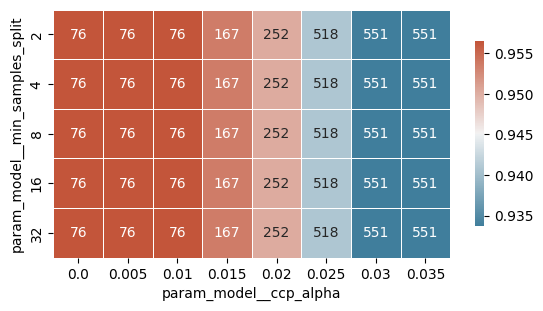

criterion = gini  max_depth: 3


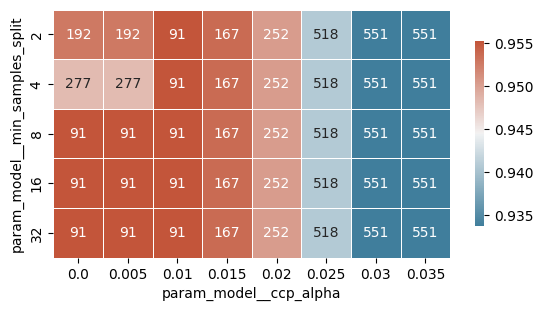

criterion = gini  max_depth: 4


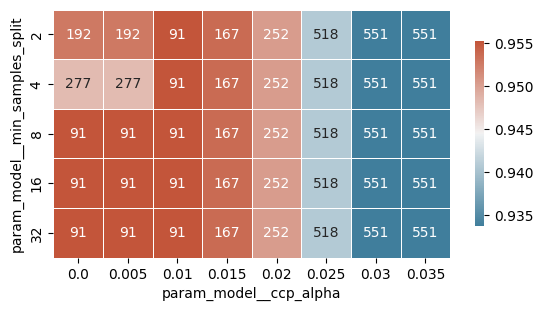

criterion = gini  max_depth: 5


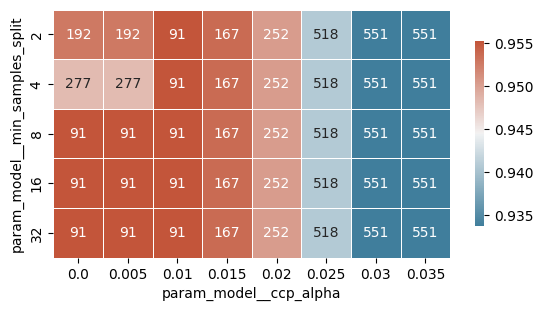

criterion = gini  max_depth: None
criterion = entropy  max_depth: 2


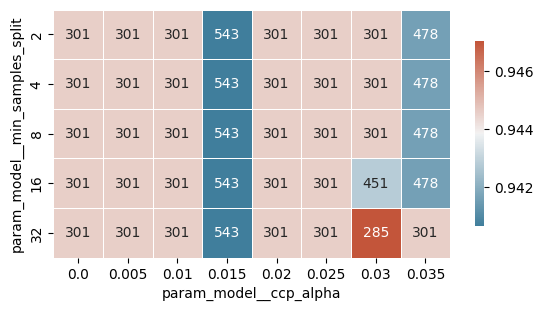

criterion = entropy  max_depth: 3


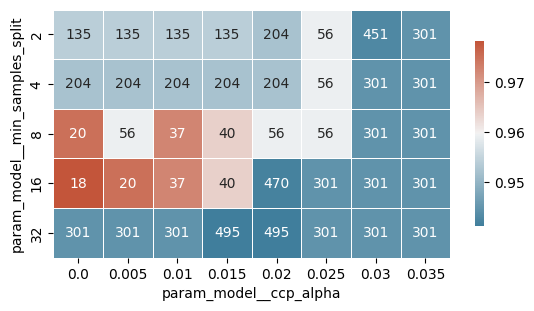

criterion = entropy  max_depth: 4


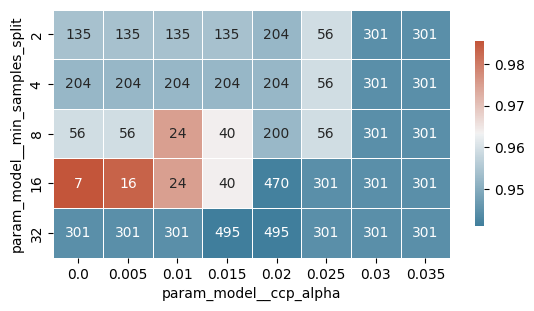

criterion = entropy  max_depth: 5


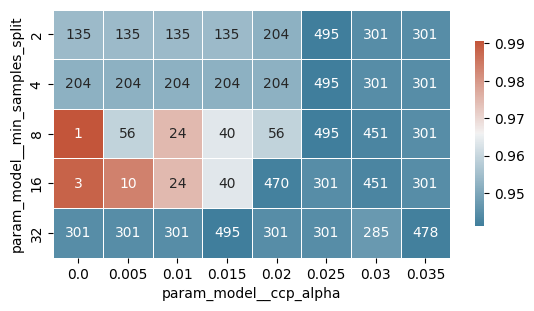

criterion = entropy  max_depth: None
criterion = log_loss  max_depth: 2


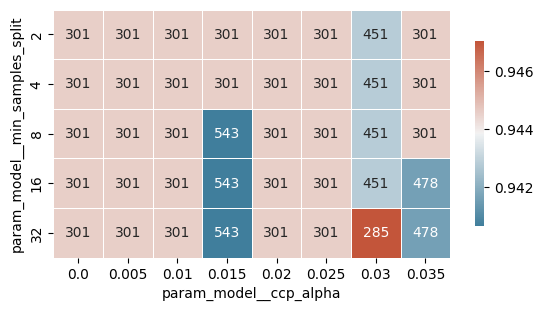

criterion = log_loss  max_depth: 3


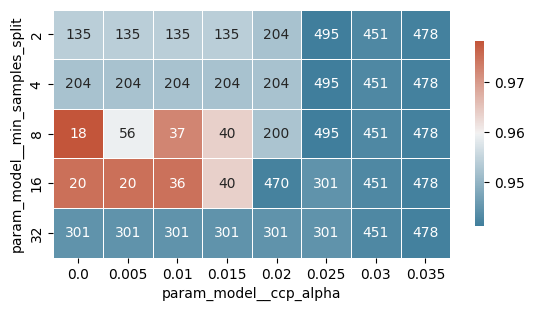

criterion = log_loss  max_depth: 4


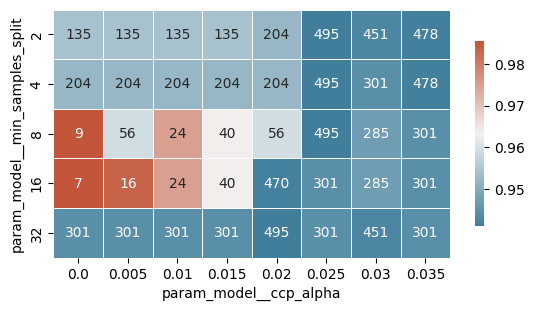

criterion = log_loss  max_depth: 5


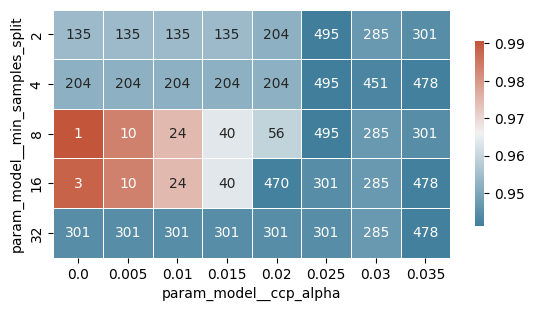

criterion = log_loss  max_depth: None


In [25]:
report_results(results)

### Fine-tuning for the most promising region

In [35]:
param_grid = {
    'model__criterion': ['entropy', 'log_loss'],
    'model__max_depth': [4, 5, 6, 7],
    'model__min_samples_split': [6, 8, 10, 12, 14, 16],
    'model__ccp_alpha': [0., 0.001, 0.002, 0.003, 0.004, 0.005]
}

results = get_search_results(X_train, y_train, param_grid)

n_iterations: 6
n_required_iterations: 9
n_possible_iterations: 6
min_resources_: 200
max_resources_: 8103
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 288
n_resources: 200
Fitting 50 folds for each of 288 candidates, totalling 14400 fits
----------
iter: 1
n_candidates: 144
n_resources: 400
Fitting 50 folds for each of 144 candidates, totalling 7200 fits
----------
iter: 2
n_candidates: 72
n_resources: 800
Fitting 50 folds for each of 72 candidates, totalling 3600 fits
----------
iter: 3
n_candidates: 36
n_resources: 1600
Fitting 50 folds for each of 36 candidates, totalling 1800 fits
----------
iter: 4
n_candidates: 18
n_resources: 3200
Fitting 50 folds for each of 18 candidates, totalling 900 fits
----------
iter: 5
n_candidates: 9
n_resources: 6400
Fitting 50 folds for each of 9 candidates, totalling 450 fits


Best parameters:
{'model__ccp_alpha': 0.0, 'model__criterion': 'entropy', 'model__max_depth': 7, 'model__min_samples_split': 8}

Best score:
0.9908249074787626

criterion = entropy  max_depth: 4


C:\Users\Judit\AppData\Local\Temp\ipykernel_26004\640356365.py:22: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  data = df_p.pivot(index='param_model__min_samples_split', columns='param_model__ccp_alpha', values='mean_test_score')
C:\Users\Judit\AppData\Local\Temp\ipykernel_26004\640356365.py:23: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  annot = df_p.pivot(index='param_model__min_samples_split', columns='param_model__ccp_alpha', values='rank')


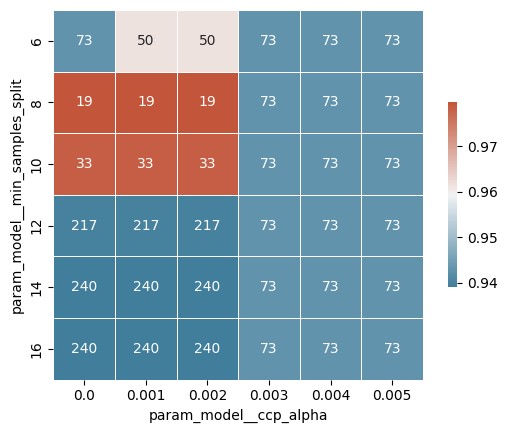

criterion = entropy  max_depth: 7


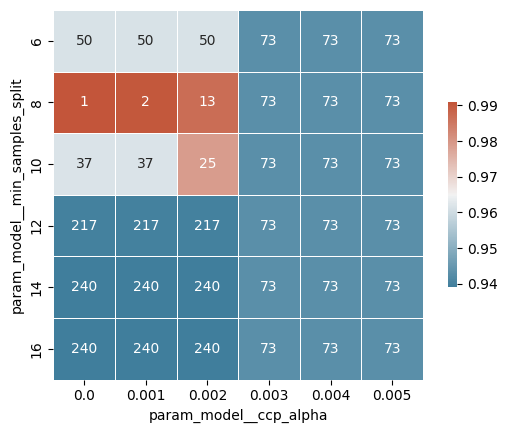

criterion = entropy  max_depth: 5


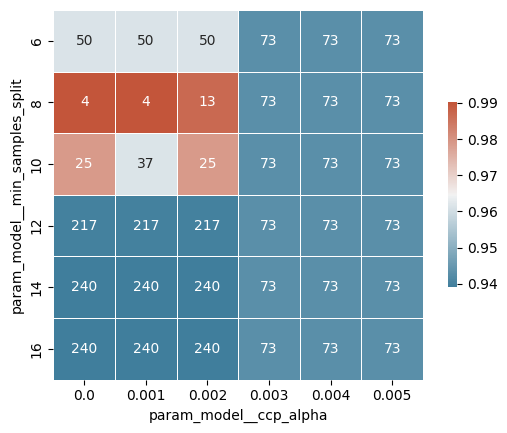

criterion = entropy  max_depth: 6


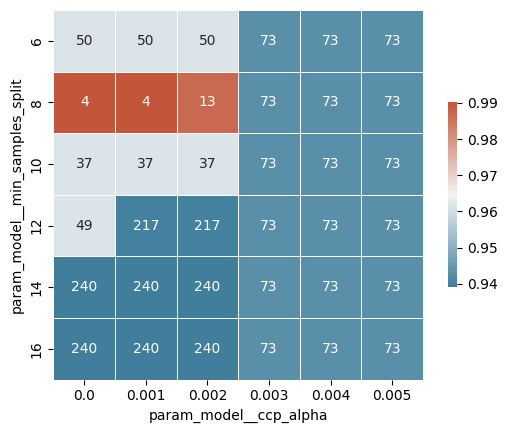

criterion = log_loss  max_depth: 4


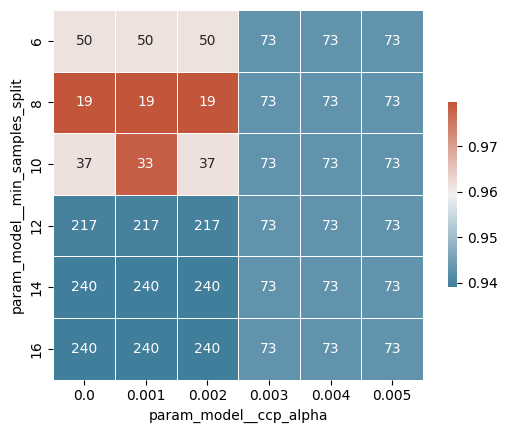

criterion = log_loss  max_depth: 7


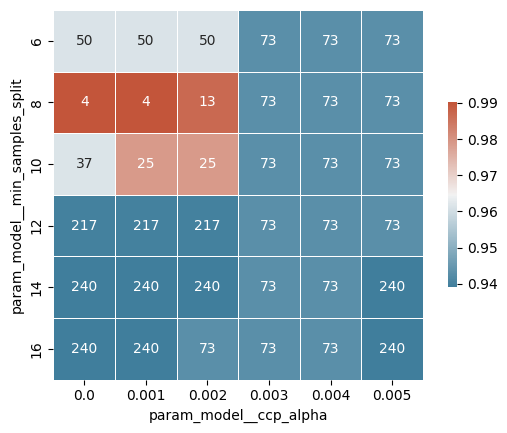

criterion = log_loss  max_depth: 5


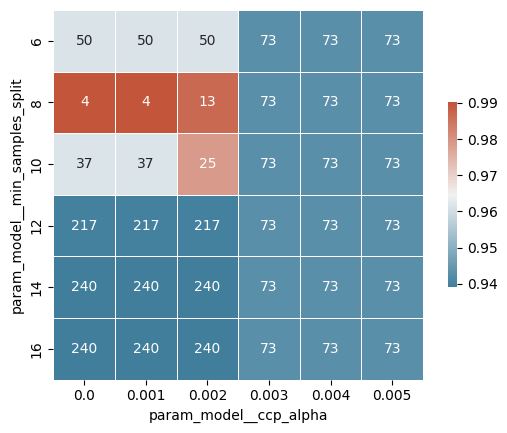

criterion = log_loss  max_depth: 6


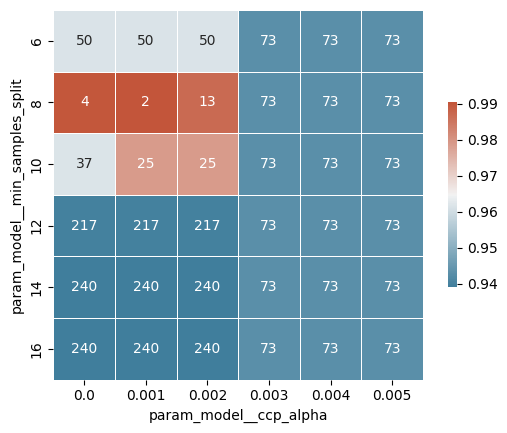

In [36]:
report_results(results)

### Fine-tuning for the most promising region

In [40]:
param_grid = {
    'model__criterion': ['entropy', 'log_loss'],
    'model__max_depth': [5, 6, 7, 8, 9, 10],
    'model__min_samples_split': [4, 5, 6, 7, 8, 9, 10],
    'model__ccp_alpha': [0., 0.001]
}

results = get_search_results(X_train, y_train, param_grid)

n_iterations: 6
n_required_iterations: 8
n_possible_iterations: 6
min_resources_: 200
max_resources_: 8103
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 168
n_resources: 200
Fitting 50 folds for each of 168 candidates, totalling 8400 fits
----------
iter: 1
n_candidates: 84
n_resources: 400
Fitting 50 folds for each of 84 candidates, totalling 4200 fits
----------
iter: 2
n_candidates: 42
n_resources: 800
Fitting 50 folds for each of 42 candidates, totalling 2100 fits
----------
iter: 3
n_candidates: 21
n_resources: 1600
Fitting 50 folds for each of 21 candidates, totalling 1050 fits
----------
iter: 4
n_candidates: 11
n_resources: 3200
Fitting 50 folds for each of 11 candidates, totalling 550 fits
----------
iter: 5
n_candidates: 6
n_resources: 6400
Fitting 50 folds for each of 6 candidates, totalling 300 fits


Best parameters:
{'model__ccp_alpha': 0.0, 'model__criterion': 'entropy', 'model__max_depth': 9, 'model__min_samples_split': 4}

Best score:
0.9924868895368868

criterion = entropy  ccp_alpha: 0.0


C:\Users\Judit\AppData\Local\Temp\ipykernel_26004\1582905328.py:22: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  data = df_p.pivot(index='param_model__min_samples_split', columns='param_model__max_depth', values='mean_test_score')
C:\Users\Judit\AppData\Local\Temp\ipykernel_26004\1582905328.py:23: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  annot = df_p.pivot(index='param_model__min_samples_split', columns='param_model__max_depth', values='rank')


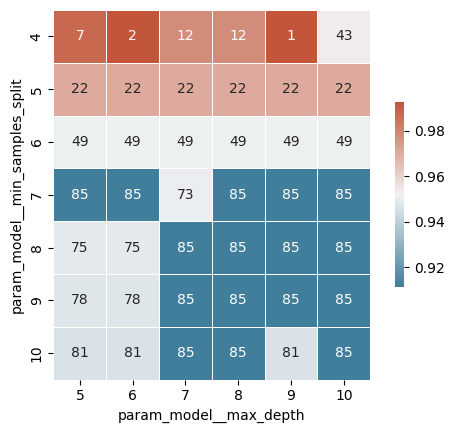

criterion = entropy  ccp_alpha: 0.001


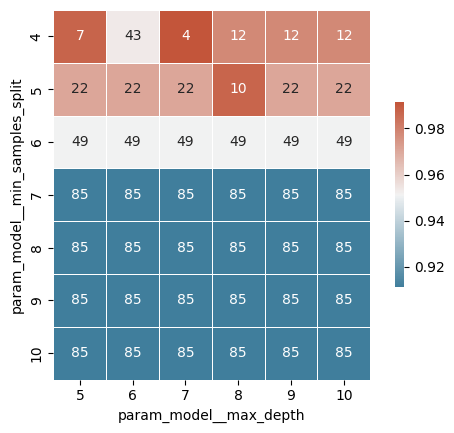

criterion = log_loss  ccp_alpha: 0.0


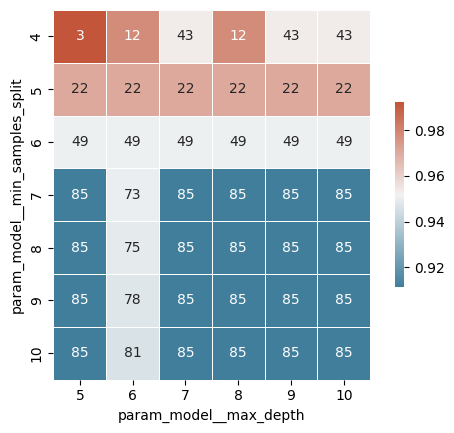

criterion = log_loss  ccp_alpha: 0.001


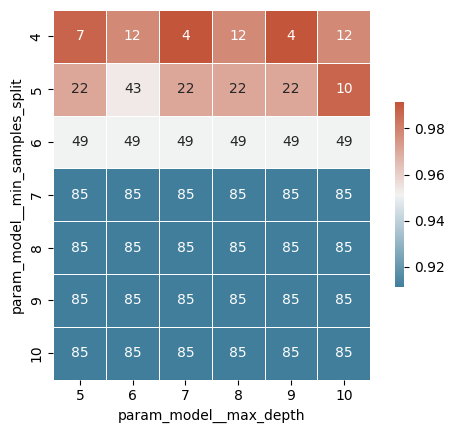

In [41]:
report_results(results)

### Fine-tuning for the most promising region

In [46]:
param_grid = {
    'model__criterion': ['entropy', 'log_loss'],
    'model__max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12],
    'model__min_samples_split': [4, 5, 6],
    'model__ccp_alpha': [0.,]
}

results = get_search_results(X_train, y_train, param_grid)

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 253
max_resources_: 8103
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 54
n_resources: 253
Fitting 50 folds for each of 54 candidates, totalling 2700 fits
----------
iter: 1
n_candidates: 27
n_resources: 506
Fitting 50 folds for each of 27 candidates, totalling 1350 fits
----------
iter: 2
n_candidates: 14
n_resources: 1012
Fitting 50 folds for each of 14 candidates, totalling 700 fits
----------
iter: 3
n_candidates: 7
n_resources: 2024
Fitting 50 folds for each of 7 candidates, totalling 350 fits
----------
iter: 4
n_candidates: 4
n_resources: 4048
Fitting 50 folds for each of 4 candidates, totalling 200 fits
----------
iter: 5
n_candidates: 2
n_resources: 8096
Fitting 50 folds for each of 2 candidates, totalling 100 fits


Best parameters:
{'model__ccp_alpha': 0.0, 'model__criterion': 'log_loss', 'model__max_depth': 12, 'model__min_samples_split': 4}

Best score:
0.9925585976763491

criterion = entropy  ccp_alpha: 0.0


C:\Users\Judit\AppData\Local\Temp\ipykernel_26004\1582905328.py:22: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  data = df_p.pivot(index='param_model__min_samples_split', columns='param_model__max_depth', values='mean_test_score')
C:\Users\Judit\AppData\Local\Temp\ipykernel_26004\1582905328.py:23: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  annot = df_p.pivot(index='param_model__min_samples_split', columns='param_model__max_depth', values='rank')


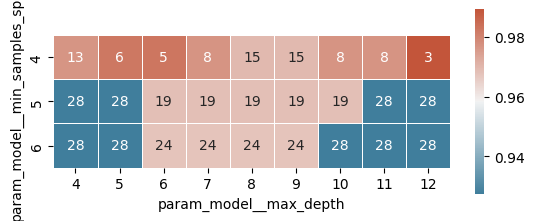

criterion = log_loss  ccp_alpha: 0.0


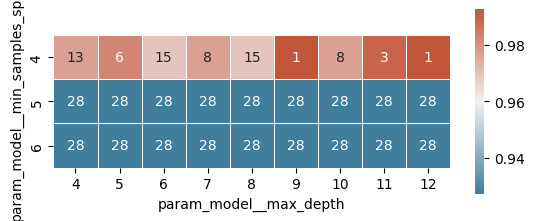

In [48]:
report_results(results)

## Best model cross-validation performance

In [49]:
scores = pd.DataFrame(results.cv_results_).filter(regex='split\d{1,2}_test', axis=1).iloc[results.best_index_, :].to_list()
mean = np.mean(scores)
median = np.median(scores)
lower = max(0.0, np.percentile(scores, 2.5))
upper = min(1.0, np.percentile(scores, 97.5))
print(f"Mean: {mean:.4f}")
print(f"Median: {median:.4f}")
print(f"95% confidence interval: ({lower:.4f} - {upper:.4f})")

Mean: 0.9926
Median: 0.9940
95% confidence interval: (0.9787 - 1.0000)


## Evaluate best model on hold-out test dataset

In [50]:
y_pred = results.best_estimator_.predict(X_test)

In [51]:
# Classification report
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9988    1.0000    0.9994      1646
           1     1.0000    0.9947    0.9974       380

    accuracy                         0.9990      2026
   macro avg     0.9994    0.9974    0.9984      2026
weighted avg     0.9990    0.9990    0.9990      2026



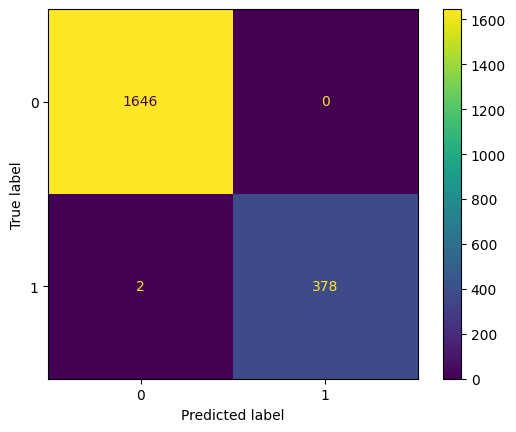

In [52]:
# Confusion matrix
ConfusionMatrixDisplay.from_estimator(results.best_estimator_, X_test, y_test)
plt.show()

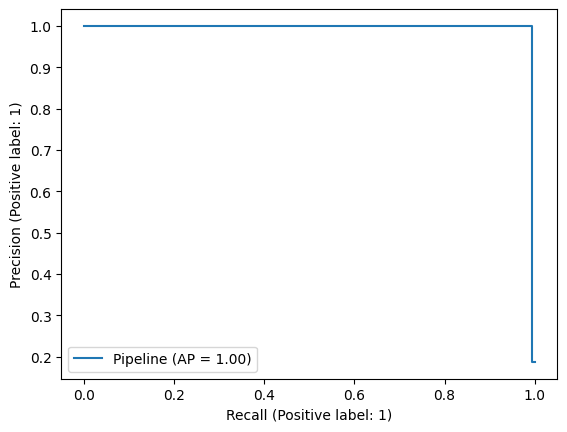

In [53]:
# Precision - Recall curve
PrecisionRecallDisplay.from_estimator(results.best_estimator_, X_test, y_test)
plt.show()

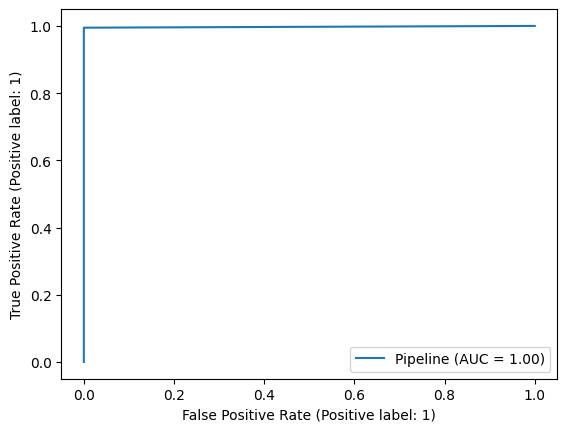

In [54]:
# ROC curve
RocCurveDisplay.from_estimator(results.best_estimator_, X_test, y_test)
plt.show()